In [172]:
import numpy as np

import torch
from torchvision import transforms

import beacon

from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import Generator3D

In [173]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [174]:
train_data = Generator3D.generate(300, 120, 92, 32)
test_data = Generator3D.generate(300, 120, 92, 1)

train_data_noisy = Generator3D.add_noise(train_data, p=0.0001)
test_data_noisy = Generator3D.add_noise(test_data, p=0.0001)

In [175]:
train_data.shape   # (batch size, features, t, x, y)

torch.Size([32, 300, 120, 92])

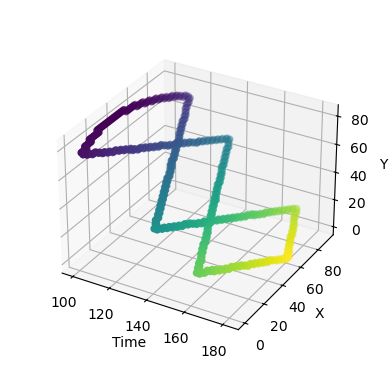

In [176]:
Generator3D.plot(train_data[0])

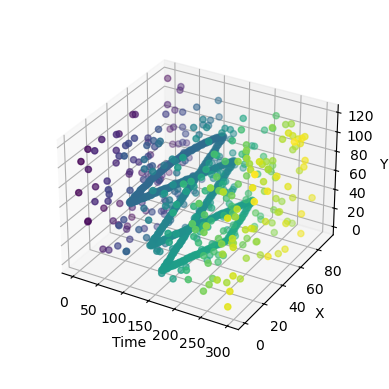

In [177]:
Generator3D.plot(train_data_noisy[0])

In [178]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(300, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 300, 3, stride=1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [179]:
summary(ConvolutionAutoencoder(), input_size=(1, 300, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [1, 300, 120, 92]         --
├─Sequential: 1-1                        [1, 8, 114, 86]           --
│    └─Conv2d: 2-1                       [1, 64, 118, 90]          172,864
│    └─BatchNorm2d: 2-2                  [1, 64, 118, 90]          128
│    └─ReLU: 2-3                         [1, 64, 118, 90]          --
│    └─Conv2d: 2-4                       [1, 16, 116, 88]          9,232
│    └─BatchNorm2d: 2-5                  [1, 16, 116, 88]          32
│    └─ReLU: 2-6                         [1, 16, 116, 88]          --
│    └─Conv2d: 2-7                       [1, 8, 114, 86]           1,160
│    └─BatchNorm2d: 2-8                  [1, 8, 114, 86]           16
│    └─ReLU: 2-9                         [1, 8, 114, 86]           --
├─Sequential: 1-2                        [1, 300, 120, 92]         --
│    └─ConvTranspose2d: 2-10             [1, 16, 116, 88]          1,168


In [180]:
# autoencoder = ConvolutionAutoencoder()
# autoencoder.compile(optimiser=torch.optim.Adam, loss_function=torch.nn.MSELoss, learning_rate=0.01, device=device)

In [181]:
# loss = autoencoder.fit_tensor(train_data_noisy, train_data, epochs=500)

In [182]:
autoencoder = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

In [183]:
autoencoder.train()

for epoch in tqdm(range(100)):
    optimiser.zero_grad()
    outputs = autoencoder(train_data_noisy.to(device))
    loss = loss_function(outputs, train_data.to(device))
    loss.backward()
    optimiser.step()

100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


In [192]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data.to("cpu"))

In [193]:
result = torch.where(pred < 0.01, torch.tensor(0.0), pred)

In [194]:
result.shape

torch.Size([1, 300, 120, 92])

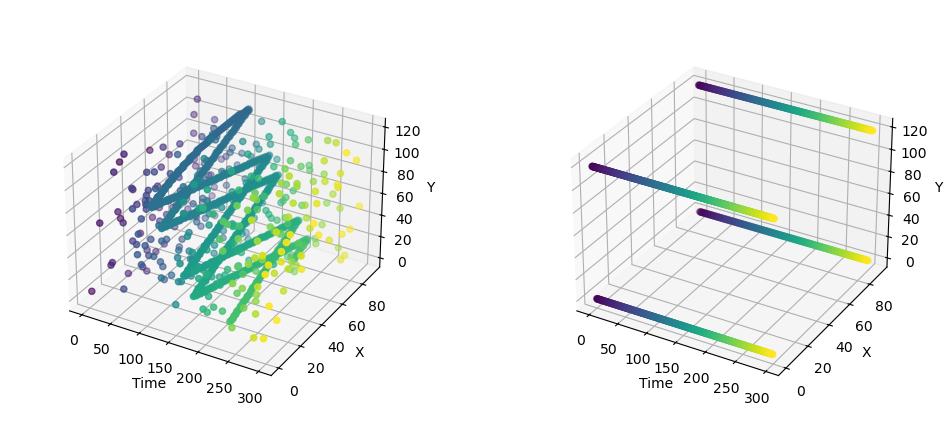

In [195]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
timed_data_nonezero = test_data_noisy[0].nonzero()
ax1.scatter(timed_data_nonezero[:, 0], timed_data_nonezero[:, 2], timed_data_nonezero[:, 1], c=timed_data_nonezero[:, 0])
ax1.set_xlabel('Time')
ax1.set_ylabel('X')
ax1.set_zlabel('Y')
ax1.set_box_aspect(None, zoom=0.85)

# ax1.view_init(elev=0, azim=40)

ax1 = fig.add_subplot(122, projection='3d')
timed_data_nonezero = result[0].nonzero()
ax1.scatter(timed_data_nonezero[:, 0], timed_data_nonezero[:, 2], timed_data_nonezero[:, 1], c=timed_data_nonezero[:, 0])
ax1.set_xlabel('Time')
ax1.set_ylabel('X')
ax1.set_zlabel('Y')
ax1.set_box_aspect(None, zoom=0.85)

# ax1.view_init(elev=0, azim=40)
